In [7]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from geophires_x_client import GeophiresXClient
from geophires_x_client.geophires_input_parameters import GeophiresInputParameters

example_file_path = Path('examples/example3.txt').absolute()

client = GeophiresXClient()
result = client.get_geophires_result(
            GeophiresInputParameters(from_file_path=example_file_path)
        )

with open(result.output_file_path,'r') as f:
    print(f.read())

[2023-11-20 12:44:14][WARNING] Parameter given (400.0) for Maximum Temperature is being set by the input file to a value that is the same as the default. No change was made to that value. Recommendation: remove the Maximum Temperature from the input file unless you wish to change it from the default value of (400.0)
[2023-11-20 12:44:14][WARNING] Parameter given (1) for Number of Segments is being set by the input file to a value that is the same as the default. No change was made to that value. Recommendation: remove the Number of Segments from the input file unless you wish to change it from the default value of (1)
[2023-11-20 12:44:14][WARNING] Parameter given (1000.0) for Reservoir Heat Capacity is being set by the input file to a value that is the same as the default. No change was made to that value. Recommendation: remove the Reservoir Heat Capacity from the input file unless you wish to change it from the default value of (1000.0)
[2023-11-20 12:44:14][WARNING] Parameter given

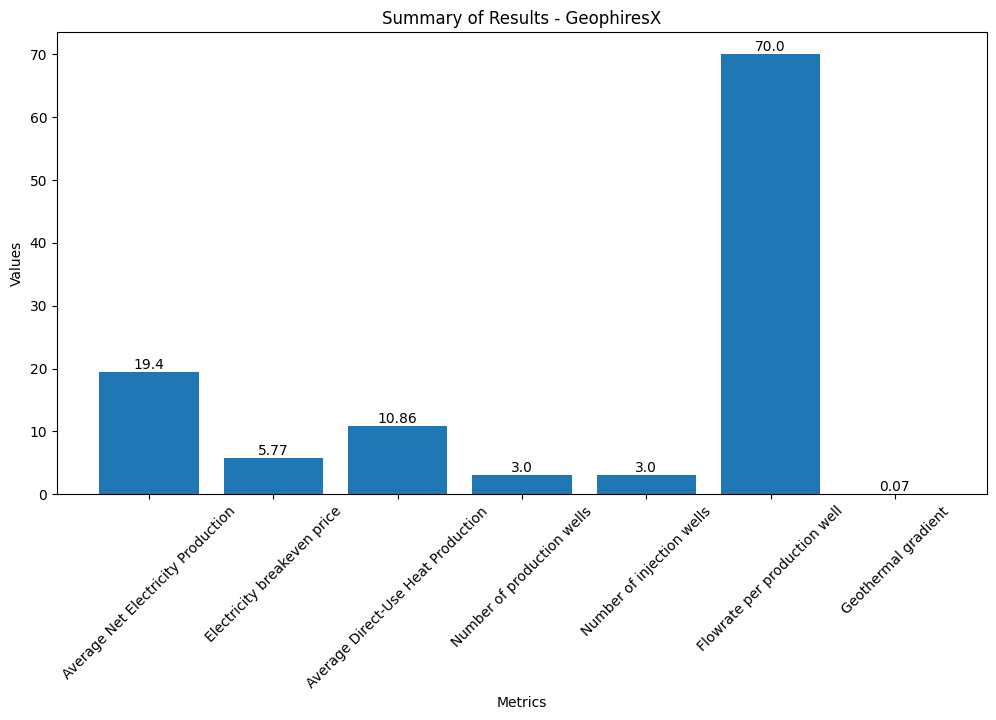

In [9]:
# Assuming 'result' is your GeophiresXResult object
summary_of_results = result.result.get('SUMMARY OF RESULTS', {})

# Convert to JSON and save to file
json_data = json.dumps(summary_of_results, indent=4)
with open('summary_of_results.json', 'w') as file:
    file.write(json_data)
    
# Load JSON data
with open('summary_of_results.json', 'r') as file:
    data = json.load(file)

# Process data to extract numeric values
processed_data = {}
for key, value in data.items():
    if isinstance(value, dict) and 'value' in value:
        processed_data[key] = value['value']
    else:
        processed_data[key] = None  # or some default value, e.g., 0

# Convert processed data to DataFrame
df = pd.DataFrame([processed_data])

# Drop columns with None values for cleaner plotting
df = df.dropna(axis=1)

plt.figure(figsize=(12, 6))
bars = plt.bar(df.columns, df.iloc[0])
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Summary of Results - GeophiresX')
plt.xticks(rotation=45)

# Annotate each bar with its value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), 
             va='bottom', ha='center')

plt.show()

In [ ]:
# # Creating a complete text representation of the data structure in a downloadable format, without using ... placeholders

# | Category                          | Fields                                                |
# |-----------------------------------|-------------------------------------------------------|
# | SUMMARY OF RESULTS                | End-Use                                               |
# |                                   | Average Net Electricity Production                    |
# |                                   | Electricity breakeven price                           |
# |                                   | Average Direct-Use Heat Production                    |
# |                                   | Direct-Use heat breakeven price                       |
# |                                   | Annual District Heating Demand                        |
# |                                   | Average Cooling Production                            |
# |                                   | Average Annual Geothermal Heat Production             |
# |                                   | Average Annual Peaking Fuel Heat Production           |
# |                                   | Direct-Use Cooling Breakeven Price                    |
# |                                   | Number of production wells                            |
# |                                   | Number of injection wells                             |
# |                                   | Flowrate per production well                          |
# |                                   | Well depth                                            |
# |                                   | Geothermal gradient                                   |
# |                                   | Segment 1 Geothermal gradient                         |
# |                                   | Segment 1 Thickness                                   |
# |                                   | Segment 2 Geothermal gradient                         |
# |                                   | Segment 2 Thickness                                   |
# |                                   | Segment 3 Geothermal gradient                         |
# |                                   | Segment 3 Thickness                                   |
# |                                   | Segment 4 Geothermal gradient                         |
# |                                   | LCOE                                                  |
# |                                   | LCOH                                                  |
# |                                   | Lifetime Average Well Flow Rate                       |
# | ECONOMIC PARAMETERS               | Economic Model                                        |
# |                                   | Interest Rate                                         |
# |                                   | Accrued financing during construction                 |
# |                                   | Project lifetime                                      |
# |                                   | Capacity factor                                       |
# |                                   | Project NPV                                           |
# |                                   | Project IRR                                           |
# |                                   | Project VIR=PI=PIR                                    |
# |                                   | Project MOIC                                          |
# |                                   | Fixed Charge Rate (FCR)                               |
# | ENGINEERING PARAMETERS            | Number of Production Wells                            |
# |                                   | Number of Injection Wells                             |
# |                                   | Well depth (or total length, if not vertical)         |
# |                                   | Water loss rate                                       |
# |                                   | Pump efficiency                                       |
# |                                   | Injection temperature                                 |
# |                                   | Injection Temperature                                 |
# |                                   | Average production well temperature drop              |
# |                                   | Flowrate per production well                          |
# |                                   | Injection well casing ID                              |
# |                                   | Production well casing ID                             |
# |                                   | Number of times redrilling                            |
# |                                   | Fluid                                                |
# |                                   | Design                                               |
# |                                   | Flow rate                                            |
# |                                   | Lateral Length                                        |
# |                                   | Vertical Depth                                        |
# |                                   | Wellbore Diameter                                     |
# |                                   | Lifetime Average Well Flow Rate                       |
# |                                   | Injection well casing ID                              |
# |                                   | Production well casing ID                             |
# | RESOURCE CHARACTERISTICS          | Maximum reservoir temperature                         |
# |                                   | Number of segments                                    |
# |                                   | Geothermal gradient                                   |
# |                                   | Segment 1 Geothermal gradient                         |
# |                                   | Segment 1 Thickness                                   |
# |                                   | Segment 2 Geothermal gradient                         |
# |                                   | Segment 2 Thickness                                   |
# |                                   | Segment 3 Geothermal gradient                         |
# |                                   | Segment 3 Thickness                                   |
# |                                   | Segment 4 Geothermal gradient                         |
# | RESERVOIR PARAMETERS              | Reservoir Model                                       |
# |                                   | Fracture model                                        |
# |                                   | Bottom-hole temperature                               |
# |                                   | Well separation: fracture height                      |
# |                                   | Fracture area                                         |
# |                                   | Fracture width                                        |
# |                                   | Reservoir volume                                      |
# |                                   | Reservoir hydrostatic pressure                        |
# |                                   | Plant outlet pressure                                 |
# |                                   | Production wellhead pressure                          |
# |                                   | Productivity Index                                    |
# |                                   | Injectivity Index                                     |
# |                                   | Reservoir density                                     |
# |                                   | Reservoir thermal conductivity                        |
# |                                   | Reservoir heat capacity                               |
# |                                   | Reservoir porosity                                    |
# |                                   | Thermal Conductivity                                  |
# | RESERVOIR SIMULATION RESULTS      | Maximum Production Temperature                        |
# |                                   | Average Production Temperature                        |
# |                                   | Minimum Production Temperature                        |
# |                                   | Initial Production Temperature                        |
# |                                   | Average Reservoir Heat Extraction                     |
# |                                   | Production Wellbore Heat Transmission Model           |
# |                                   | Average Production Well Temperature Drop              |
# |                                   | Average Injection Well Pump Pressure Drop             |
# |                                   | Average Production Well Pump Pressure Drop            |
# |                                   | Average Production Pressure                           |
# |                                   | Average Heat Production                               |
# |                                   | First Year Heat Production                            |
# |                                   | Average Net Electricity Production                    |
# |                                   | First Year Electricity Production                     |
# |                                   | Maximum Storage Well Temperature                      |
# |                                   | Average Storage Well Temperature                      |
# |                                   | Minimum Storage Well Temperature                      |
# |                                   | Maximum Balance Well Temperature                      |
# |                                   | Average Balance Well Temperature                      |
# |                                   | Minimum Balance Well Temperature                      |
# |                                   | Maximum Annual Heat Stored                            |
# |                                   | Average Annual Heat Stored
